In [1]:
import numpy as np 
import csv, os, json 
import pandas as pd


# DATA FILES

In [2]:
results_folder = "./results/"
result_files_ = ["result_20240509_042718",  # FROM AVERTEC DATASET
                 "result_20240509_144451",  # FROM AVERTEC DATASET
                 "result_20240509_194950",  # FROM POLITIFACT DATASET
                 "result_20240509_235154",  # FROM POLITIFACT DATASET
                 "result_20240510_055604",  # FROM SNOPES DATASET  
                 ]
result_files_path = [results_folder + _result_file + ".csv" 
                                for _result_file in result_files_]
assert all(map(os.path.exists, result_files_path))

# SAVING DATA

In [34]:
def merge_csv_files(filepaths, output_filename="./merge_csv_files.csv"):
    """
    Merges multiple CSV files into one.

    Args:
        filepaths (list): List of file paths to CSV files.
        output_filename (str): Name of the final merged CSV file.

    Returns:
        int: 1 if merge is successful, 0 otherwise.
    """
    try:
        # Initialize an empty DataFrame
        merged_df = pd.DataFrame()

        # Read each CSV file and append to the merged DataFrame
        for filepath in filepaths:
            df = pd.read_csv(filepath, encoding="utf-8",
                             quoting=3, escapechar='\\')
            print(df.head())
            input()
            merged_df = pd.concat(merged_df, df, ignore_index=True)

        # Save the merged DataFrame to a new CSV file
        merged_df.to_csv(output_filename, index=False)
        return 1  # Successful merge
    except Exception as e:
        print(f"Error during merge: {e}")
        return 0  # Merge failed

In [27]:
merge_csv_files(result_files_path)

Error during merge: Error tokenizing data. C error: Expected 5 fields in line 3, saw 6



0

In [29]:
pd.read_csv(result_files_path[0], encoding="utf-8")

ParserError: Error tokenizing data. C error: Expected 5 fields in line 3, saw 6


In [76]:
# import json

def extract_data_from_csv(input_file, output_file):
    data = []
    countt = 0
    with open(input_file, 'r') as csvfile:
      
        for line in csvfile:
            if countt == 0:
                countt+=1
                continue

            pred_start_index = line.find("{'True':")
            # print(pred_start_index)
            if pred_start_index != -1:
                claim_label_text = line[:pred_start_index]
                claim_label_parts = claim_label_text.split(',')
                # print(claim_label_parts)
                # input()
                label = claim_label_parts[-2].strip()
                claim = ','.join(claim_label_parts[:-2]).strip()
                prediction_str = line[pred_start_index:].strip()
                prediction = eval(prediction_str)  # Safely evaluate the prediction string as a dictionary
                data.append({
                    'Claim': claim,
                    'Label': label,
                    'Prediction': prediction
                })
            countt+=1

    with open(output_file, 'w') as jsonfile:
        json.dump(data, jsonfile, indent=4)
    return data

In [73]:
output_file = 'output.json'
input_file = result_files_path[0]

In [77]:
input_file, output_file

('./results/result_20240509_042718.csv', 'output.json')

In [78]:
print(len(extract_data_from_csv(input_file, output_file)))

36


In [85]:
result_json_files_path = []
merged_json_file = "./merged_results.json"
merged_json = []
for result_file in result_files_path:
    output_file = results_folder+os.path.basename(result_file)[:-4]+".json"
    print(result_file, output_file)
    result_json_files_path.append(output_file)
    extracted_json = extract_data_from_csv(result_file, output_file)
    print(len(extracted_json))
    merged_json += extracted_json

    

./results/result_20240509_042718.csv ./results/result_20240509_042718.json
36
./results/result_20240509_144451.csv ./results/result_20240509_144451.json
21
./results/result_20240509_194950.csv ./results/result_20240509_194950.json
14
./results/result_20240509_235154.csv ./results/result_20240509_235154.json
33
./results/result_20240510_055604.csv ./results/result_20240510_055604.json
43


In [80]:
result_json_files_path

['./results/result_20240509_042718.json',
 './results/result_20240509_144451.json',
 './results/result_20240509_194950.json',
 './results/result_20240509_235154.json',
 './results/result_20240510_055604.json',
 './results/result_20240510_055604.json']

In [86]:
with open(merged_json_file, "w", encoding="utf-8") as json_f:
    json.dump(merged_json, json_f, indent=3)

In [87]:
len(merged_json)

147

# ANALYSIS

In [3]:
merged_json_file = "./merged_results.json"
merged_json = []
with open(merged_json_file, "r", encoding="utf-8") as json_f:
    merged_json = json.load(json_f)
len(merged_json)

147

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import numpy as np


# T AND F

In [5]:
def decide_True_False_Un(predictions):
  """
  Decides the label (True, False, or Unknown) based on prediction probabilities.

  Args:
      predictions (dict): Dictionary containing probabilities for 'True', 'False', and 'PantsOnFire'.

  Returns:
      int:
          1 - True
          0 - False
          -1 - Unknown
          None - Invalid prediction (all probabilities are zero)
  """

  # Check for invalid predictions (all probabilities zero)
  if sum(predictions.values()) == 0:
    return -1 # None

  # Extract probabilities for True and Not True (combining False and PantsOnFire)
  prob_true = predictions['True']
  prob_not_true = sum(predictions.values()) - prob_true

  # Prioritize Unknown if PantsOnFire probability is high
  if predictions['PantsOnFire'] > 0.8:
    return -1

  # Decision logic based on True probability and Not True probability
  if prob_true > prob_not_true:
    return 1
  elif prob_true < prob_not_true:
    return 0
  else:
    return -1  # If True and Not True probabilities are equal, consider Unknown


def decide_True_False(predictions):
    decision = None
    if isinstance(predictions, dict):
        decision = decide_True_False_Un(predictions = predictions)
    elif isinstance(predictions, int):
        decision = predictions

    if decision is not None:
        if decision == 1:
            return 1
        elif decision in [0, -1]:
            return 0
    return
    
 
def one_hot_code(label, include_unknown = False):
    mapp = {"True" : 1,
            "False" : 0,
            "Unknown" : -1}
    if include_unknown:
        return mapp[label]
    return decide_True_False(mapp[label])

In [6]:

def evaluate_model_performance(true_labels, predictions):
    """
    Evaluates the performance of a classification model.

    Args:
        true_labels (list): The true labels of the data.
        predictions (list): The predicted labels by the model.

    Returns:
        dict: A dictionary containing the performance metrics.
    """
    # Calculate the performance metrics
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    macro_f = f1_score(true_labels, predictions, average='macro')

    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')

    # Create a dictionary to hold the metrics
    performance_metrics = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'macro_F' : macro_f,
        'Precision': precision,
        'Recall': recall
    }

    return performance_metrics

In [7]:
data_label = []
predicted_label = []
countt = 0
for i in merged_json:
    # print(i['Label'], i['Prediction'])
    # print(one_hot_code(i['Label']), decide_True_False(i['Prediction']))
    data_label.append(one_hot_code(i['Label']))
    predicted_label.append(decide_True_False(i['Prediction']))
    # predicted_label.append(decide_True_False_Un(i['Prediction']))

    countt+=1
    # input()
print(countt)

147


In [8]:
kappa = cohen_kappa_score(data_label, predicted_label)
kappa

0.1128743853375056

In [9]:
accuracy_score(data_label, predicted_label)

0.6326530612244898

In [11]:
true_labels = data_label  
predictions = predicted_label  

metrics = evaluate_model_performance(true_labels, predictions)
print(metrics)


{'Accuracy': 0.6326530612244898, 'F1 Score': 0.611661807580175, 'macro_F': 0.55, 'Precision': 0.6055413315768785, 'Recall': 0.6326530612244898}


In [12]:
conf_matrix = confusion_matrix(true_labels, predicted_label)
print(conf_matrix)

[[78 19]
 [35 15]]


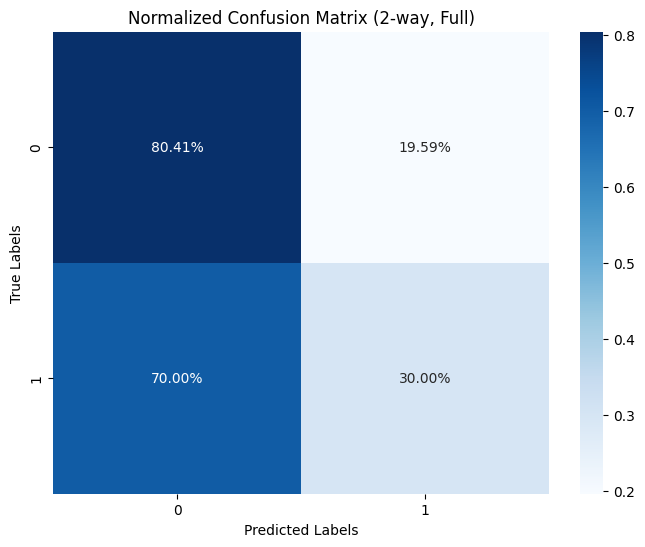

In [13]:

# # Assuming you have two lists: 'true_labels' and 'predicted_labels'
# true_labels = [...]  # Replace with your actual list of true labels
# predicted_labels = [...]  # Replace with your actual list of predicted labels

# Generate the confusion matrix
cf_matrix = confusion_matrix(true_labels, predictions)

# Normalize the confusion matrix
cf_matrix_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues')

# Add labels to the x-axis and the y-axis
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

# Add a title
plt.title('Normalized Confusion Matrix (2-way, Full)')

# Show the plot
plt.show()


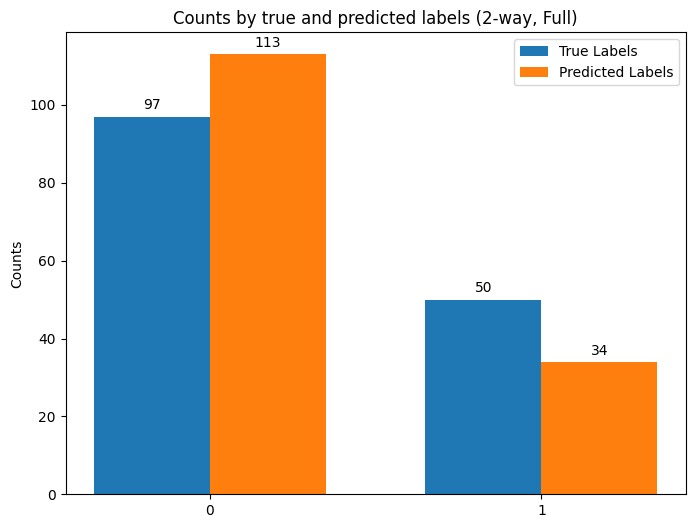

In [14]:
# Sample data
# true_labels = [...]  # Replace with your actual list of true labels
# predicted_labels = [...]  # Replace with your actual list of predicted labels

# Count the occurrences of each label
true_counts = [true_labels.count(0), true_labels.count(1)]
predicted_counts = [predicted_label.count(0), predicted_label.count(1)]

# Set the positions of the bars
ind = np.arange(len(true_counts))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size here
rects1 = ax.bar(ind - width/2, true_counts, width, label='True Labels')
rects2 = ax.bar(ind + width/2, predicted_counts, width, label='Predicted Labels')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Counts by true and predicted labels (2-way, Full)')
ax.set_xticks(ind)
ax.set_xticklabels(('0', '1'))
ax.legend()

# Function to attach a text label above each bar, displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Show the plot
plt.show()


# T, F AND Un

In [26]:
data_label = []
predicted_label = []
countt = 0
for i in merged_json:
    # print(i['Label'], i['Prediction'])
    # print(one_hot_code(i['Label']), decide_True_False(i['Prediction']))
    data_label.append(one_hot_code(i['Label'], include_unknown=True))
    # predicted_label.append(decide_True_False(i['Prediction']))
    predicted_label.append(decide_True_False_Un(i['Prediction']))

    countt+=1
    # input()
print(countt)

147


In [27]:
set(data_label), set(predicted_label)

({-1, 0, 1}, {-1, 0, 1})

In [28]:
kappa = cohen_kappa_score(data_label, predicted_label)
kappa

0.046329595938227275

In [29]:
true_labels = data_label  # Replace with your list of true labels
predictions = predicted_label  # Replace with your list of predictions
metrics = evaluate_model_performance(true_labels, predictions)
print(metrics)

{'Accuracy': 0.3741496598639456, 'F1 Score': 0.3906760927405802, 'macro_F': 0.35209098137805267, 'Precision': 0.4375264607734645, 'Recall': 0.3741496598639456}


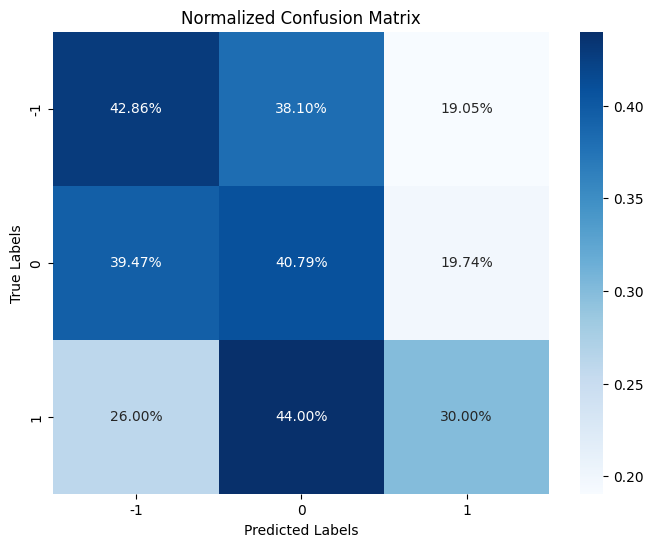

In [30]:
# Generate the confusion matrix
cf_matrix = confusion_matrix(true_labels, predicted_label)

# Normalize the confusion matrix
cf_matrix_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

labels = [-1, 0 , 1]
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# Add labels to the x-axis and the y-axis
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

# Add a title
plt.title('Normalized Confusion Matrix')

# Show the plot
plt.show()


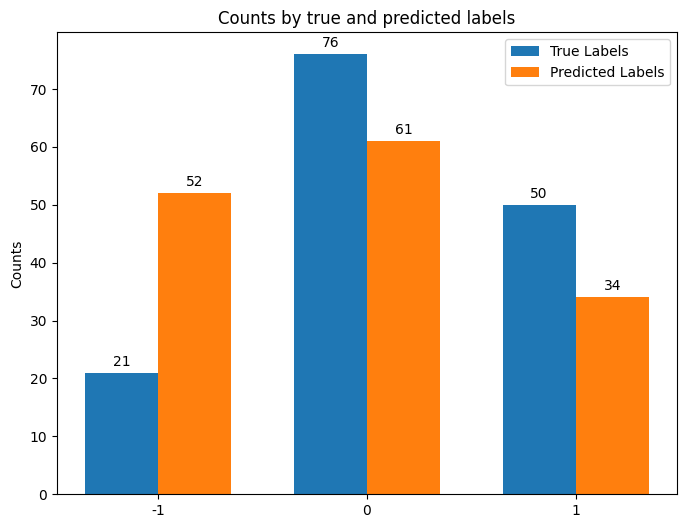

In [31]:
# Count the occurrences of each label
true_counts = [ true_labels.count(-1), true_labels.count(0), true_labels.count(1)]
predicted_counts = [predicted_label.count(-1), predicted_label.count(0), predicted_label.count(1)]

# Set the positions of the bars
ind = np.arange(len(true_counts))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size here
rects1 = ax.bar(ind - width/2, true_counts, width, label='True Labels')
rects2 = ax.bar(ind + width/2, predicted_counts, width, label='Predicted Labels')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Counts by true and predicted labels')
ax.set_xticks(ind)
ax.set_xticklabels(('-1', '0', '1'))
ax.legend()

# Function to attach a text label above each bar, displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Show the plot
plt.show()


# FOR AVERTEC DATASET ONLY

In [41]:
result_json_files_path = []
for result_file in result_files_path[:]:
    result_json_files_path.append(results_folder+os.path.basename(result_file)[:-4]+".json")

In [42]:
avertec_result_files = result_json_files_path[:2]
avertec_result_files

['./results/result_20240509_042718.json',
 './results/result_20240509_144451.json']

In [43]:
avertec_results = []
for filee in avertec_result_files:
    print(filee)
    with open(filee, "r", encoding="utf-8") as json_f:
        # print(json_f)
        avertec_results += json.load(json_f)

./results/result_20240509_042718.json
./results/result_20240509_144451.json


### T and F

In [44]:
aver_data_label = []
aver_predicted_label = []
countt = 0
for i in avertec_results:
    # print(i['Label'], i['Prediction'])
    # print(one_hot_code(i['Label']), decide_True_False(i['Prediction']))
    aver_data_label.append(one_hot_code(i['Label']))
    aver_predicted_label.append(decide_True_False(i['Prediction']))
    # predicted_label.append(decide_True_False_Un(i['Prediction']))

    countt+=1
    # input()
print(countt)

57


In [45]:
kappa = cohen_kappa_score(aver_data_label, aver_predicted_label)
kappa

0.2852664576802507

In [46]:
true_labels = aver_data_label  # Replace with your list of true labels
predictions = aver_predicted_label  # Replace with your list of predictions
metrics = evaluate_model_performance(true_labels, predictions)
print(metrics)

{'Accuracy': 0.7192982456140351, 'F1 Score': 0.6787317130034388, 'macro_F': 0.6212624584717608, 'Precision': 0.7268170426065164, 'Recall': 0.7192982456140351}


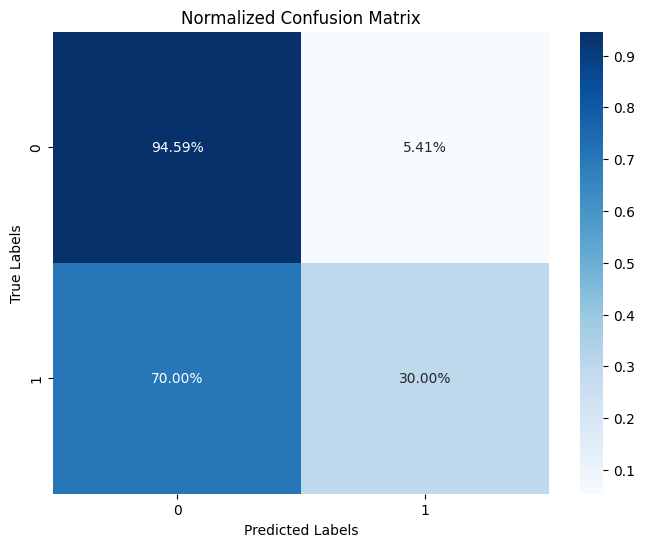

In [47]:

# # Assuming you have two lists: 'true_labels' and 'predicted_labels'
# true_labels = [...]  # Replace with your actual list of true labels
# predicted_labels = [...]  # Replace with your actual list of predicted labels

# Generate the confusion matrix
cf_matrix = confusion_matrix(true_labels, predictions)

# Normalize the confusion matrix
cf_matrix_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
labels = [0, 1]
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# Add labels to the x-axis and the y-axis
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

# Add a title
plt.title('Normalized Confusion Matrix')

# Show the plot
plt.show()


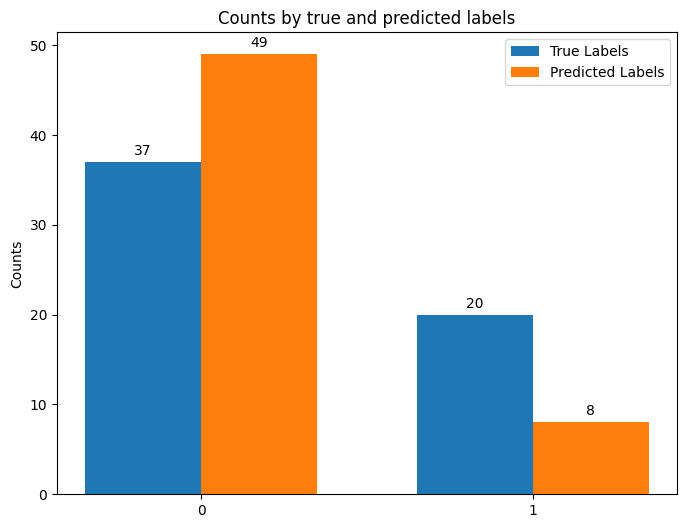

In [48]:
# Sample data
# true_labels = [...]  # Replace with your actual list of true labels
# predicted_labels = [...]  # Replace with your actual list of predicted labels

# Count the occurrences of each label
true_counts = [true_labels.count(0), true_labels.count(1)]
predicted_counts = [predictions.count(0), predictions.count(1)]

# Set the positions of the bars
ind = np.arange(len(true_counts))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size here
rects1 = ax.bar(ind - width/2, true_counts, width, label='True Labels')
rects2 = ax.bar(ind + width/2, predicted_counts, width, label='Predicted Labels')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Counts by true and predicted labels')
ax.set_xticks(ind)
ax.set_xticklabels(('0', '1'))
ax.legend()

# Function to attach a text label above each bar, displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Show the plot
plt.show()


### T, F, UN

In [49]:
aver_data_label = []
aver_predicted_label = []
countt = 0
for i in avertec_results:
    # print(i['Label'], i['Prediction'])
    # print(one_hot_code(i['Label']), decide_True_False(i['Prediction']))
    aver_data_label.append(one_hot_code(i['Label'], include_unknown=True))
    # predicted_label.append(decide_True_False(i['Prediction']))
    aver_predicted_label.append(decide_True_False_Un(i['Prediction']))

    countt+=1
    # input()
print(countt)

57


In [50]:
kappa = cohen_kappa_score(aver_data_label, aver_predicted_label)
kappa

0.17622377622377616

In [51]:
true_labels = aver_data_label  # Replace with your list of true labels
predictions = aver_predicted_label  # Replace with your list of predictions
metrics = evaluate_model_performance(true_labels, predictions)
print(metrics)

{'Accuracy': 0.45614035087719296, 'F1 Score': 0.45601424946012825, 'macro_F': 0.44779329684990055, 'Precision': 0.5441845354126056, 'Recall': 0.45614035087719296}


[[ 7  4  0]
 [11 13  2]
 [ 4 10  6]]


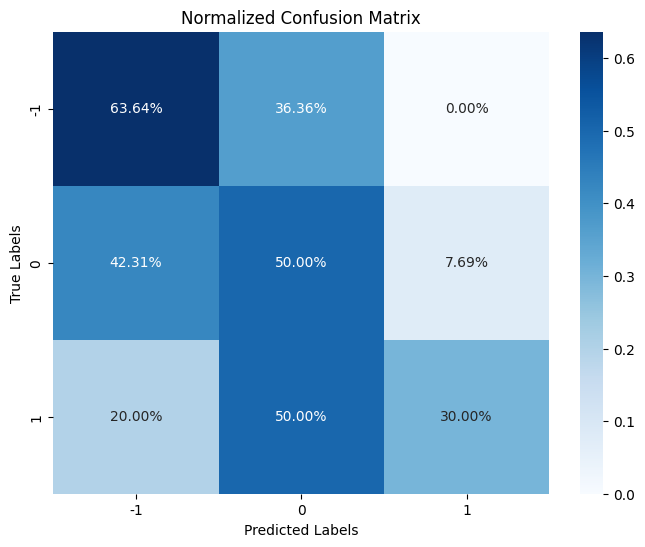

In [52]:

# Generate the confusion matrix
cf_matrix = confusion_matrix(true_labels, predictions)
print(cf_matrix)

# Normalize the confusion matrix
cf_matrix_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

labels = [-1, 0, 1]
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# Add labels to the x-axis and the y-axis
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

# Add a title
plt.title('Normalized Confusion Matrix')

# Show the plot
plt.show()


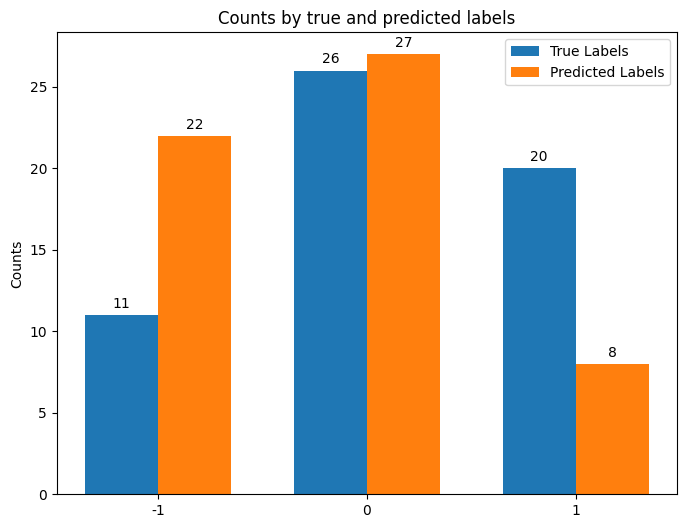

In [53]:
# Count the occurrences of each label
true_counts = [true_labels.count(-1), true_labels.count(0), true_labels.count(1)]
predicted_counts = [predictions.count(-1), predictions.count(0), predictions.count(1)]

# Set the positions of the bars
ind = np.arange(len(true_counts))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size here
rects1 = ax.bar(ind - width/2, true_counts, width, label='True Labels')
rects2 = ax.bar(ind + width/2, predicted_counts, width, label='Predicted Labels')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Counts by true and predicted labels')
ax.set_xticks(ind)
ax.set_xticklabels(('-1', '0', '1'))
ax.legend()

# Function to attach a text label above each bar, displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Show the plot
plt.show()


# PolitiFact Dataset

In [5]:
result_json_files_path = []
for result_file in result_files_path[:]:
    result_json_files_path.append(results_folder+os.path.basename(result_file)[:-4]+".json")

In [8]:
politi_result_files = result_json_files_path[2:4]
politi_result_files

['./results/result_20240509_194950.json',
 './results/result_20240509_235154.json']

In [9]:
politi_results = []
for filee in politi_result_files:
    print(filee)
    with open(filee, "r", encoding="utf-8") as json_f:
        # print(json_f)
        politi_results += json.load(json_f)

./results/result_20240509_194950.json
./results/result_20240509_235154.json


### T and F

In [23]:
politi_data_label = []
politi_predicted_label = []
countt = 0
for i in politi_results:
    # print(i['Label'], i['Prediction'])
    # print(one_hot_code(i['Label']), decide_True_False(i['Prediction']))
    politi_data_label.append(one_hot_code(i['Label']))
    politi_predicted_label.append(decide_True_False(i['Prediction']))
    # predicted_label.append(decide_True_False_Un(i['Prediction']))

    countt+=1
    # input()
print(countt)

47


In [24]:
kappa = cohen_kappa_score(politi_data_label, politi_predicted_label)
kappa

-0.03160667251975435

In [25]:
true_labels = politi_data_label  # Replace with your list of true labels
predictions = politi_predicted_label  # Replace with your list of predictions
metrics = evaluate_model_performance(true_labels, predictions)
print(metrics)

{'Accuracy': 0.46808510638297873, 'F1 Score': 0.4352975595976716, 'macro_F': 0.44286391654812707, 'Precision': 0.47993920972644377, 'Recall': 0.46808510638297873}


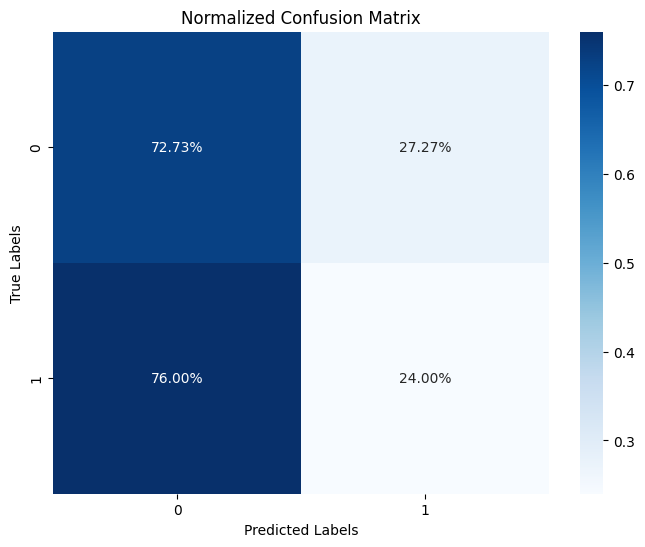

In [26]:

# # Assuming you have two lists: 'true_labels' and 'predicted_labels'
# true_labels = [...]  # Replace with your actual list of true labels
# predicted_labels = [...]  # Replace with your actual list of predicted labels

# Generate the confusion matrix
cf_matrix = confusion_matrix(true_labels, predictions)

# Normalize the confusion matrix
cf_matrix_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
labels = [0, 1]
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# Add labels to the x-axis and the y-axis
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

# Add a title
plt.title('Normalized Confusion Matrix')

# Show the plot
plt.show()


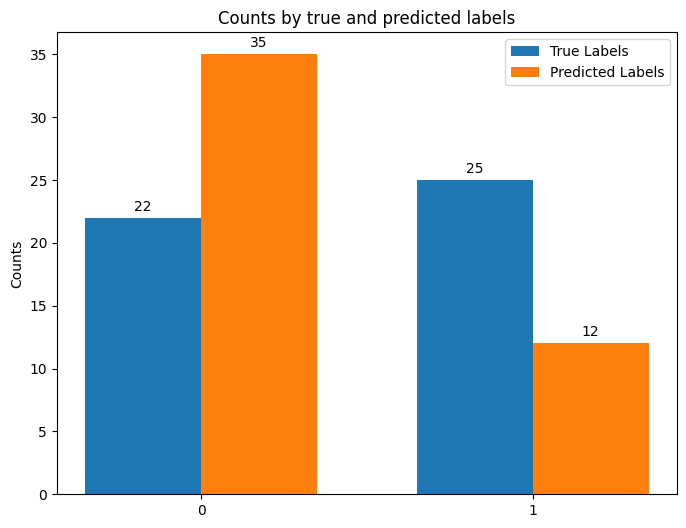

In [27]:
# Sample data
# true_labels = [...]  # Replace with your actual list of true labels
# predicted_labels = [...]  # Replace with your actual list of predicted labels

# Count the occurrences of each label
true_counts = [true_labels.count(0), true_labels.count(1)]
predicted_counts = [predictions.count(0), predictions.count(1)]

# Set the positions of the bars
ind = np.arange(len(true_counts))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size here
rects1 = ax.bar(ind - width/2, true_counts, width, label='True Labels')
rects2 = ax.bar(ind + width/2, predicted_counts, width, label='Predicted Labels')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Counts by true and predicted labels')
ax.set_xticks(ind)
ax.set_xticklabels(('0', '1'))
ax.legend()

# Function to attach a text label above each bar, displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Show the plot
plt.show()


# SNOPES DATASET

In [28]:
result_json_files_path = []
for result_file in result_files_path[:]:
    result_json_files_path.append(results_folder+os.path.basename(result_file)[:-4]+".json")

In [30]:
snop_result_files = result_json_files_path[4:]
snop_result_files

['./results/result_20240510_055604.json']

In [32]:
snop_results = []
for filee in snop_result_files:
    print(filee)
    with open(filee, "r", encoding="utf-8") as json_f:
        # print(json_f)
        snop_results += json.load(json_f)

./results/result_20240510_055604.json


### T AND F

In [34]:
snop_data_label = []
snop_predicted_label = []
countt = 0
for i in snop_results:
    # print(i['Label'], i['Prediction'])
    # print(one_hot_code(i['Label']), decide_True_False(i['Prediction']))
    snop_data_label.append(one_hot_code(i['Label']))
    snop_predicted_label.append(decide_True_False(i['Prediction']))
    # predicted_label.append(decide_True_False_Un(i['Prediction']))

    countt+=1
    # input()
print(countt)

43


In [35]:
kappa = cohen_kappa_score(snop_data_label, snop_predicted_label)
kappa

0.1742983751846382

In [36]:
true_labels = snop_data_label  # Replace with your list of true labels
predictions = snop_predicted_label  # Replace with your list of predictions
metrics = evaluate_model_performance(true_labels, predictions)
print(metrics)

{'Accuracy': 0.6976744186046512, 'F1 Score': 0.7489723962805312, 'macro_F': 0.5608798114689708, 'Precision': 0.8476916027036315, 'Recall': 0.6976744186046512}


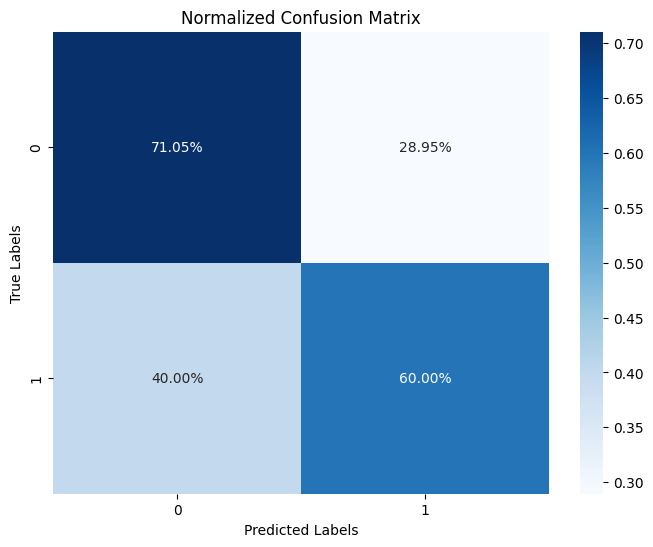

In [37]:
# # Assuming you have two lists: 'true_labels' and 'predicted_labels'
# true_labels = [...]  # Replace with your actual list of true labels
# predicted_labels = [...]  # Replace with your actual list of predicted labels

# Generate the confusion matrix
cf_matrix = confusion_matrix(true_labels, predictions)

# Normalize the confusion matrix
cf_matrix_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
labels = [0, 1]
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# Add labels to the x-axis and the y-axis
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

# Add a title
plt.title('Normalized Confusion Matrix')

# Show the plot
plt.show()


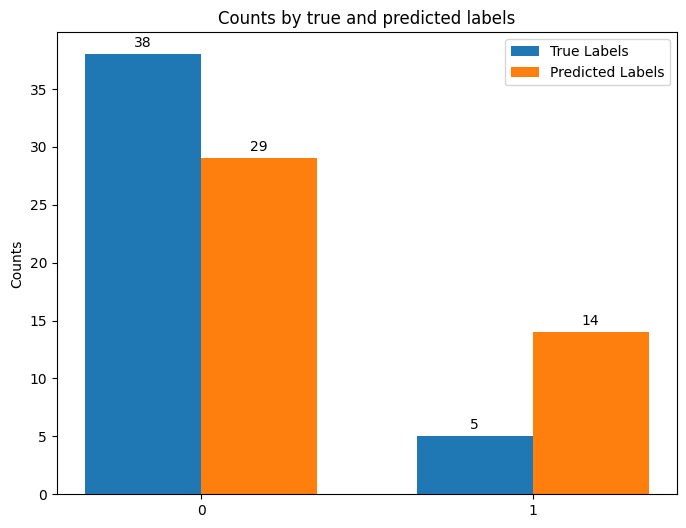

In [38]:
# Sample data
# true_labels = [...]  # Replace with your actual list of true labels
# predicted_labels = [...]  # Replace with your actual list of predicted labels

# Count the occurrences of each label
true_counts = [true_labels.count(0), true_labels.count(1)]
predicted_counts = [predictions.count(0), predictions.count(1)]

# Set the positions of the bars
ind = np.arange(len(true_counts))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size here
rects1 = ax.bar(ind - width/2, true_counts, width, label='True Labels')
rects2 = ax.bar(ind + width/2, predicted_counts, width, label='Predicted Labels')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Counts by true and predicted labels')
ax.set_xticks(ind)
ax.set_xticklabels(('0', '1'))
ax.legend()

# Function to attach a text label above each bar, displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Show the plot
plt.show()


### T, F, UN

In [40]:
snop_data_label = []
snop_predicted_label = []
countt = 0
for i in snop_results:
    # print(i['Label'], i['Prediction'])
    # print(one_hot_code(i['Label']), decide_True_False(i['Prediction']))
    snop_data_label.append(one_hot_code(i['Label'], include_unknown=True))
    # predicted_label.append(decide_True_False(i['Prediction']))
    snop_predicted_label.append(decide_True_False_Un(i['Prediction']))

    countt+=1
    # input()
print(countt)

43


In [45]:
set(snop_data_label), set(snop_predicted_label)

({-1, 0, 1}, {-1, 0, 1})

In [41]:
kappa = cohen_kappa_score(snop_data_label, snop_predicted_label)
kappa

-0.00808407437348424

In [42]:
true_labels = snop_data_label  # Replace with your list of true labels
predictions = snop_predicted_label  # Replace with your list of predictions
metrics = evaluate_model_performance(true_labels, predictions)
print(metrics)

{'Accuracy': 0.32558139534883723, 'F1 Score': 0.3529987760097919, 'macro_F': 0.30145363408521303, 'Precision': 0.4745293466223699, 'Recall': 0.32558139534883723}


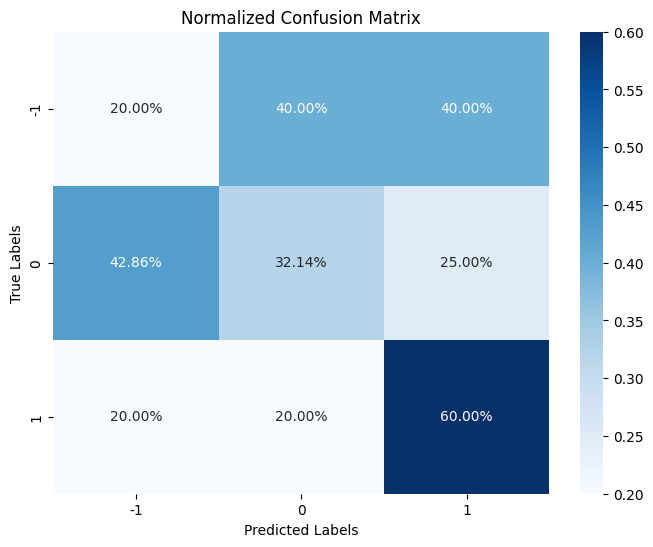

In [46]:
# # Assuming you have two lists: 'true_labels' and 'predicted_labels'
# true_labels = [...]  # Replace with your actual list of true labels
# predicted_labels = [...]  # Replace with your actual list of predicted labels

# Generate the confusion matrix
cf_matrix = confusion_matrix(true_labels, predictions)

# Normalize the confusion matrix
cf_matrix_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
labels = [-1, 0, 1]
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# Add labels to the x-axis and the y-axis
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

# Add a title
plt.title('Normalized Confusion Matrix')

# Show the plot
plt.show()


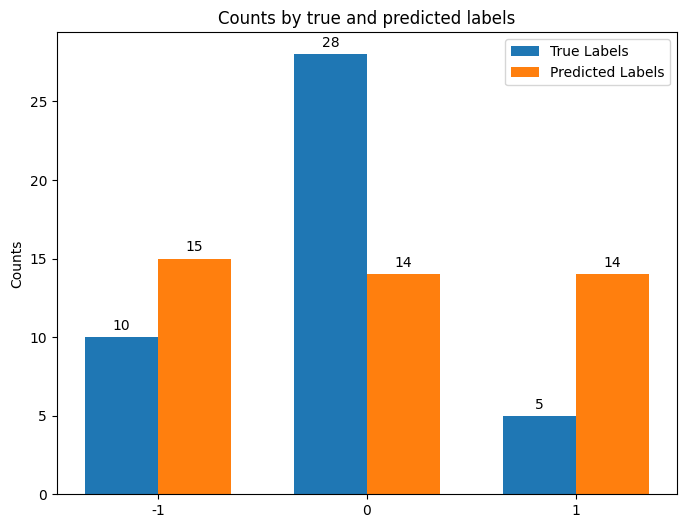

In [47]:
# Count the occurrences of each label
true_counts = [true_labels.count(-1), true_labels.count(0), true_labels.count(1)]
predicted_counts = [predictions.count(-1), predictions.count(0), predictions.count(1)]

# Set the positions of the bars
ind = np.arange(len(true_counts))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size here
rects1 = ax.bar(ind - width/2, true_counts, width, label='True Labels')
rects2 = ax.bar(ind + width/2, predicted_counts, width, label='Predicted Labels')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Counts by true and predicted labels')
ax.set_xticks(ind)
ax.set_xticklabels(('-1', '0', '1'))
ax.legend()

# Function to attach a text label above each bar, displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Show the plot
plt.show()
